## Tugas Besar II IF3270 Pembelajaran Mesin - RNN

### Anggota Kelompok:
1. Suthasoma Mahardhika Munthe (13522098)
2. Marvin Scifo Y. Hutahaean (13522110)
3. Berto Richardo Togatorop (13522118)

In [66]:
import numpy as np
import pandas as pd
from customnn import RNN, Embedded, FullyConnected, Dropout
from keras import layers
from keras import models

url_train = "https://raw.githubusercontent.com/IndoNLP/nusax/main/datasets/sentiment/indonesian/train.csv"
url_valid = "https://raw.githubusercontent.com/IndoNLP/nusax/main/datasets/sentiment/indonesian/valid.csv"
url_test = "https://raw.githubusercontent.com/IndoNLP/nusax/main/datasets/sentiment/indonesian/test.csv"

df_train = pd.read_csv(url_train)
df_valid = pd.read_csv(url_valid)
df_test = pd.read_csv(url_test)

In [67]:
max_tokens = 10000
output_sequence_length = 100

vectorizer = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode='int',
    output_sequence_length=output_sequence_length
)
vectorizer.adapt(df_train['text'])
vectorizer_data = vectorizer(df_train['text'])
vectorizer_test = vectorizer(df_test['text'])
vectorizer_val = vectorizer(df_valid['text'])
vocabs = len(vectorizer.get_vocabulary())

y_train = df_train['label'].to_numpy()
y_test = df_test['label'].to_numpy()
y_val = df_valid['label'].to_numpy()

In [68]:
embedder = Embedded(vocabs, 100, embeddings_initializer='xavier')
embedded_vector = embedder.forward(vectorizer_data)

print(embedded_vector.shape)

(500, 100, 100)


In [69]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_int = le.fit_transform(df_train['label'])
y_test_int = le.transform(df_test['label'])
y_valid_int = le.transform(df_valid['label'])

In [70]:
rnn_model = models.Sequential([
    layers.Embedding(vocabs, 100, embeddings_initializer='uniform'),
    layers.SimpleRNN(units=64, return_sequences=True),
    layers.SimpleRNN(units=128),
    layers.Dropout(0.2),
    layers.Dense(units=vocabs, activation='softmax')
])

rnn_model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=['accuracy']
)
rnn_model.fit(
    vectorizer_data, y_train_int,
    epochs=10,
    batch_size=64,
    validation_split=0.2
)
test_loss, test_acc = rnn_model.evaluate(vectorizer_test, y_test_int)

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - accuracy: 0.1036 - loss: 7.6362 - val_accuracy: 0.3600 - val_loss: 6.5074
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.4340 - loss: 6.1231 - val_accuracy: 0.3600 - val_loss: 4.7123
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.3576 - loss: 4.3218 - val_accuracy: 0.3600 - val_loss: 2.8915
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.3686 - loss: 2.5856 - val_accuracy: 0.3600 - val_loss: 1.6373
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4012 - loss: 1.5341 - val_accuracy: 0.3600 - val_loss: 1.2195
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.3362 - loss: 1.2639 - val_accuracy: 0.3600 - val_loss: 1.1219
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.3735 - loss: 1.1418 - val_accuracy: 0.4400 - val_loss: 1.0913
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.3994 - loss: 1.1100 - val_accuracy: 0.3600 - val_loss: 1.0821


In [71]:
embedding_weights = rnn_model.layers[0].get_weights()[0]
rnn_weights = rnn_model.layers[1].get_weights()
kernel, recurrent_kernel, bias_rnn = rnn_weights
rnn_weights_2 = rnn_model.layers[2].get_weights()
kernel_2, recurrent_kernel_2, bias_rnn_2 = rnn_weights_2
dense_weights = rnn_model.layers[4].get_weights()
kernel_dense, bias_dense = dense_weights

In [72]:
from sklearn.metrics import f1_score

class RNNFromScratch:
    def __init__(self, vocabs: int):
        self.embedding = Embedded(vocabs, 100, embeddings_initializer='uniform')
        self.rnn1 = RNN(unit=64, input_size=100, timestep=100, return_sequence=True)
        self.rnn2 = RNN(unit=128, input_size=64, timestep=100, return_sequence=False)
        self.drop = Dropout(dropout_rate=0.2)
        self.drop.training_status = False
        self.fc1 = FullyConnected(input_size=128, output_size=vocabs, activation='softmax', weight_init='xavier',
                                  lower=-0.05, upper=0.05, mean=0, variance=1, seed=None, use_rmsnorm=False)

    def forward(self, x):
        return self.fc1.forward(self.drop.forward(self.rnn2.forward(self.rnn1.forward(self.embedding.forward(x)))))
    
rnn_from_scratch = RNNFromScratch(vocabs=vocabs)

rnn_from_scratch.embedding.weight = embedding_weights.copy()
rnn_from_scratch.rnn1.input_weights = kernel.copy()
rnn_from_scratch.rnn1.hidden_weights = recurrent_kernel.copy()
rnn_from_scratch.rnn1.bias = bias_rnn.copy()
rnn_from_scratch.rnn2.input_weights = kernel_2.copy()
rnn_from_scratch.rnn2.hidden_weights = recurrent_kernel_2.copy()
rnn_from_scratch.rnn2.bias = bias_rnn_2.copy()
rnn_from_scratch.fc1.weights = kernel_dense.copy()
rnn_from_scratch.fc1.biases = bias_dense.copy()

sample_input = vectorizer_data.numpy()

keras_output = rnn_model(sample_input, training=False).numpy()

outputs = []
for i in range(sample_input.shape[0]):
    x = sample_input[i]
    output = rnn_from_scratch.forward(x)
    outputs.append(output)

outputs = np.stack(outputs)

keras_labels = np.argmax(keras_output, axis=1)
scratch_labels = np.argmax(outputs, axis=1)

f1 = f1_score(keras_labels, scratch_labels, average='macro')

print("Difference:", np.abs(keras_output - outputs).mean())
print("F1:", f1)


Difference: 2.8841895007936555e-10
F1: 1.0


In [73]:
bi_models = models.Sequential([
    layers.Embedding(vocabs, 100, embeddings_initializer='uniform'),
    layers.Bidirectional(layers.SimpleRNN(units=64, return_sequences=True)),
    layers.Bidirectional(layers.SimpleRNN(units=128)),
    layers.Dropout(0.2),
    layers.Dense(units=vocabs, activation='softmax')
])
bi_models.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=['accuracy']
)
bi_models.fit(
    vectorizer_data, y_train_int,
    epochs=10,
    batch_size=64,
    validation_split=0.2
)
test_loss, test_acc = bi_models.evaluate(vectorizer_test, y_test_int)

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 0.1845 - loss: 7.4678 - val_accuracy: 0.4400 - val_loss: 5.2680
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.3782 - loss: 4.5695 - val_accuracy: 0.4400 - val_loss: 2.0044
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.3840 - loss: 1.7799 - val_accuracy: 0.4400 - val_loss: 1.1381
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.4055 - loss: 1.1749 - val_accuracy: 0.3600 - val_loss: 1.1220
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.3288 - loss: 1.1228 - val_accuracy: 0.3600 - val_loss: 1.0980
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.3127 - loss: 1.1121 - val_accuracy: 0.4400 - val_loss: 1.0529
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.3224 - loss: 1.1267 - val_accuracy: 0.3600 - val_loss: 1.0584
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.3777 - loss: 1.1072 - val_accuracy: 0.4400 - val_loss: 1.0773

In [74]:
bi_embedding_weights = bi_models.layers[0].get_weights()[0]
bi_rnn_weights = bi_models.layers[1].get_weights()
bi_kernel, bi_recurrent_kernel, bi_bias_rnn, bi_kernel_reverse, bi_recurrent_kernel_reverse, bi_bias_rnn_reverse = bi_rnn_weights
bi_rnn_weights_2 = bi_models.layers[2].get_weights()
bi_kernel_2, bi_recurrent_kernel_2, bi_bias_rnn_2, bi_kernel_reverse_2, bi_recurrent_kernel_reverse_2, bi_bias_rnn_reverse_2 = bi_rnn_weights_2
bi_dense_weights = bi_models.layers[4].get_weights()
bi_kernel_dense, bi_bias_dense = bi_dense_weights

In [75]:
class BiRNNFromScratch:
    def __init__(self, vocabs: int):
        self.embedding = Embedded(vocabs, 100, embeddings_initializer='uniform')
        self.rnn1 = RNN(unit=64, input_size=100, timestep=100, return_sequence=True, bidirectional=True)
        self.rnn2 = RNN(unit=128, input_size=64, timestep=100, return_sequence=False, bidirectional=True)
        self.drop = Dropout(dropout_rate=0.2)
        self.drop.training_status = False
        self.fc1 = FullyConnected(input_size=64, output_size=vocabs, activation='softmax', weight_init='xavier',
                                  lower=-0.05, upper=0.05, mean=0, variance=1, seed=None, use_rmsnorm=False)

    def forward(self, x):
        return self.fc1.forward(self.drop.forward(self.rnn2.forward(self.rnn1.forward(self.embedding.forward(x)))))
    
bi_rnn_from_scratch = BiRNNFromScratch(vocabs=vocabs)

bi_rnn_from_scratch.embedding.weight = bi_embedding_weights.copy()
bi_rnn_from_scratch.rnn1.input_weights = bi_kernel.copy()
bi_rnn_from_scratch.rnn1.hidden_weights = bi_recurrent_kernel.copy()
bi_rnn_from_scratch.rnn1.bias = bi_bias_rnn.copy()
bi_rnn_from_scratch.rnn1.input_weights_reverse = bi_kernel_reverse.copy()
bi_rnn_from_scratch.rnn1.hidden_weights_reverse = bi_recurrent_kernel_reverse.copy()
bi_rnn_from_scratch.rnn1.bias_reverse = bi_bias_rnn_reverse.copy()
bi_rnn_from_scratch.rnn2.input_weights = bi_kernel_2.copy()
bi_rnn_from_scratch.rnn2.hidden_weights = bi_recurrent_kernel_2.copy()
bi_rnn_from_scratch.rnn2.bias = bi_bias_rnn_2.copy()
bi_rnn_from_scratch.rnn2.input_weights_reverse = bi_kernel_reverse_2.copy()
bi_rnn_from_scratch.rnn2.hidden_weights_reverse = bi_recurrent_kernel_reverse_2.copy()
bi_rnn_from_scratch.rnn2.bias_reverse = bi_bias_rnn_reverse_2.copy()
bi_rnn_from_scratch.fc1.weights = bi_kernel_dense.copy()
bi_rnn_from_scratch.fc1.biases = bi_bias_dense.copy()

bi_sample_input = vectorizer_data.numpy()

bi_keras_output = bi_models(bi_sample_input, training=False).numpy()

bi_outputs = []
for i in range(bi_sample_input.shape[0]):
    x = bi_sample_input[i]
    bi_output = bi_rnn_from_scratch.forward(x)
    bi_outputs.append(bi_output)

bi_outputs = np.stack(bi_outputs)

bi_keras_labels = np.argmax(bi_keras_output, axis=1)
bi_scratch_labels = np.argmax(bi_outputs, axis=1)

bi_f1 = f1_score(bi_keras_labels, bi_scratch_labels, average='macro')

print("Difference:", np.abs(bi_keras_output - bi_outputs).mean())
print("F1:",bi_f1)


Difference: 3.7219731996307147e-10
F1: 1.0


In [89]:
# RNN Models Hyperparameter Analysis
rnn_models = [
    models.Sequential([
        layers.Embedding(vocabs, 100, embeddings_initializer='uniform'),
        layers.SimpleRNN(units=64),
        layers.Dropout(0.2),
        layers.Dense(units=vocabs, activation='softmax')
    ]),
    models.Sequential([
        layers.Embedding(vocabs, 100, embeddings_initializer='uniform'),
        layers.SimpleRNN(units=64, return_sequences=True),
        layers.SimpleRNN(units=128),
        layers.Dropout(0.2),
        layers.Dense(units=vocabs, activation='softmax')
    ]),
    models.Sequential([
        layers.Embedding(vocabs, 100, embeddings_initializer='uniform'),
        layers.SimpleRNN(units=64, return_sequences=True),
        layers.SimpleRNN(units=128, return_sequences=True),
        layers.SimpleRNN(units=256),
        layers.Dropout(0.2),
        layers.Dense(units=vocabs, activation='softmax')
    ]),
    models.Sequential([
        layers.Embedding(vocabs, 100, embeddings_initializer='uniform'),
        layers.SimpleRNN(units=32),
        layers.Dropout(0.2),
        layers.Dense(units=vocabs, activation='softmax')
    ]),
    models.Sequential([
        layers.Embedding(vocabs, 100, embeddings_initializer='uniform'),
        layers.SimpleRNN(units=64),
        layers.Dropout(0.2),
        layers.Dense(units=vocabs, activation='softmax')
    ]),
    models.Sequential([
        layers.Embedding(vocabs, 100, embeddings_initializer='uniform'),
        layers.SimpleRNN(units=128),
        layers.Dropout(0.2),
        layers.Dense(units=vocabs, activation='softmax')
    ]),
    models.Sequential([
        layers.Embedding(vocabs, 100, embeddings_initializer='uniform'),
        layers.SimpleRNN(units=64),
        layers.Dropout(0.2),
        layers.Dense(units=vocabs, activation='softmax')
    ]),
    models.Sequential([
        layers.Embedding(vocabs, 100, embeddings_initializer='uniform'),
        layers.Bidirectional(layers.SimpleRNN(units=64)),
        layers.Dropout(0.2),
        layers.Dense(units=vocabs, activation='softmax')
    ]),
    models.Sequential([
        layers.Embedding(vocabs, 100, embeddings_initializer='uniform'),
        layers.Bidirectional(layers.SimpleRNN(units=64, return_sequences=True)),
        layers.Bidirectional(layers.SimpleRNN(units=64)),
        layers.Dropout(0.2),
        layers.Dense(units=vocabs, activation='softmax')
    ]),
]

In [90]:
name_layers = [
    "1 Layer",
    "2 Layers",
    "3 Layers",
    "32 Cells",
    "64 Cells",
    "128 Cells",
    "Unidirectional",
    "Bidirectional",
    "Bidirectional 2 Layers"
]

1 Layer
Epoch 1/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.3817 - loss: 1.2342 - val_accuracy: 0.4400 - val_loss: 1.1355
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.3709 - loss: 1.1613 - val_accuracy: 0.4400 - val_loss: 1.1045
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.3454 - loss: 1.1352 - val_accuracy: 0.4400 - val_loss: 1.0886
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.3506 - loss: 1.1136 - val_accuracy: 0.3600 - val_loss: 1.0782
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.3325 - loss: 1.1292 - val_accuracy: 0.3600 - val_loss: 1.0792
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4097 - loss: 1.0966 - val_accuracy: 0.3600 - val_loss: 1.0769
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.3206 - loss: 1.1131 - val_accuracy: 0.3600 - val_loss: 1.0751
Epoch 8/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.3830 - loss: 1.1013 - val_accuracy: 0.3600 - val_loss:

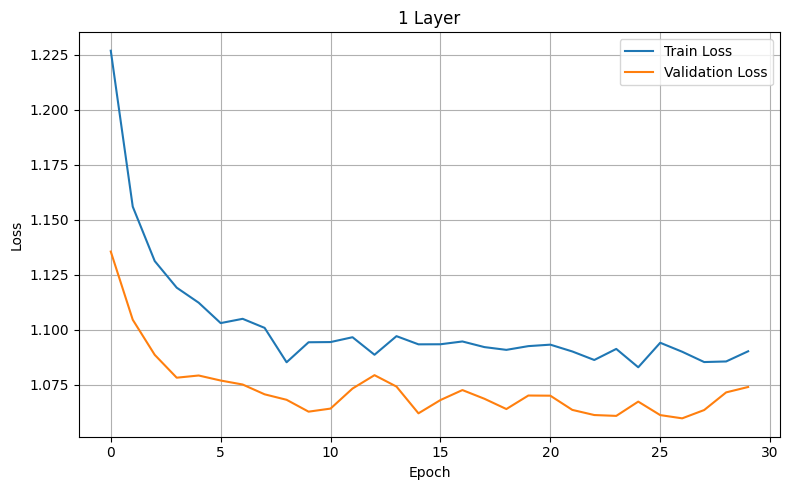


2 Layers
Epoch 1/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 217ms/step - accuracy: 0.4009 - loss: 1.1031 - val_accuracy: 0.3600 - val_loss: 1.0722
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.3781 - loss: 1.0879 - val_accuracy: 0.4400 - val_loss: 1.0598
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.3781 - loss: 1.1039 - val_accuracy: 0.3600 - val_loss: 1.0776
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.3675 - loss: 1.0960 - val_accuracy: 0.3600 - val_loss: 1.0732
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.3583 - loss: 1.1116 - val_accuracy: 0.3600 - val_loss: 1.0611
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.4094 - loss: 1.0766 - val_accuracy: 0.4400 - val_loss: 1.0593
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.3668 - loss: 1.0795 - val_accuracy: 0.3600 - val_loss: 1.0653
Epoch 8/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.4066 - loss: 1.0908 - val_accuracy: 0.3600 - val_lo

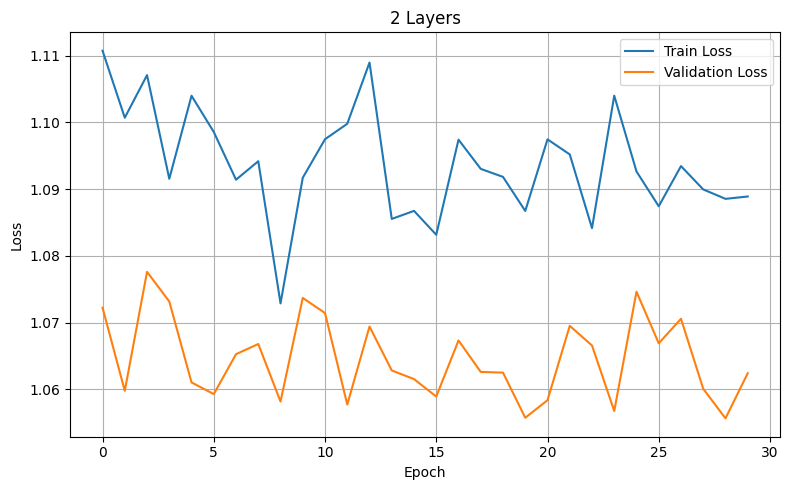


3 Layers
Epoch 1/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 174ms/step - accuracy: 0.1690 - loss: 7.2333 - val_accuracy: 0.4400 - val_loss: 4.1440
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 0.3697 - loss: 3.5147 - val_accuracy: 0.4400 - val_loss: 1.5378
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 0.3668 - loss: 1.4504 - val_accuracy: 0.4400 - val_loss: 1.1109
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.3138 - loss: 1.1449 - val_accuracy: 0.3600 - val_loss: 1.0939
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.3947 - loss: 1.0937 - val_accuracy: 0.4400 - val_loss: 1.0584
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.3501 - loss: 1.1108 - val_accuracy: 0.4400 - val_loss: 1.0584
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.3600 - loss: 1.0946 - val_accuracy: 0.3600 - val_loss: 1.0886
Epoch 8/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.3854 - loss: 1.0973 - val_accuracy: 0.3600 -

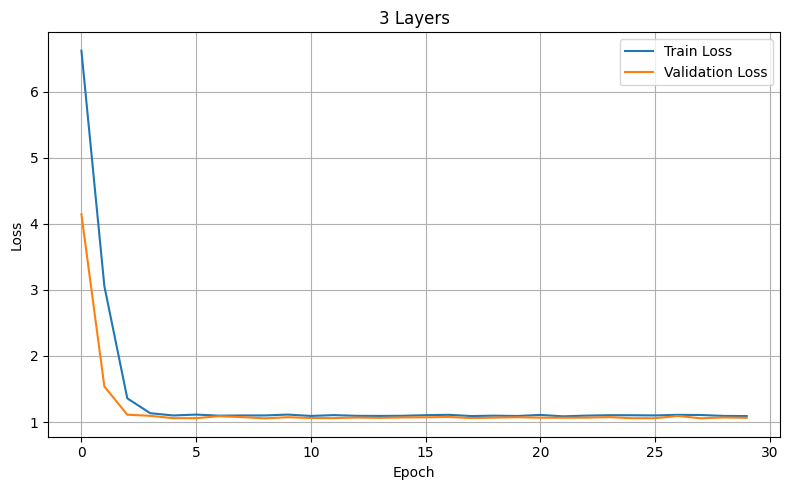


32 Cells
Epoch 1/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.0435 - loss: 7.8871 - val_accuracy: 0.4400 - val_loss: 7.6487
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.3575 - loss: 7.5777 - val_accuracy: 0.4400 - val_loss: 7.2654
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.3921 - loss: 7.1706 - val_accuracy: 0.4400 - val_loss: 6.7879
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.3497 - loss: 6.6805 - val_accuracy: 0.4400 - val_loss: 6.2474
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.3699 - loss: 6.1447 - val_accuracy: 0.4400 - val_loss: 5.6925
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.3992 - loss: 5.5965 - val_accuracy: 0.4400 - val_loss: 5.1411
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.3650 - loss: 5.0589 - val_accuracy: 0.4400 - val_loss: 4.6005
Epoch 8/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.3963 - loss: 4.4757 - val_accuracy: 0.4400 - val_los

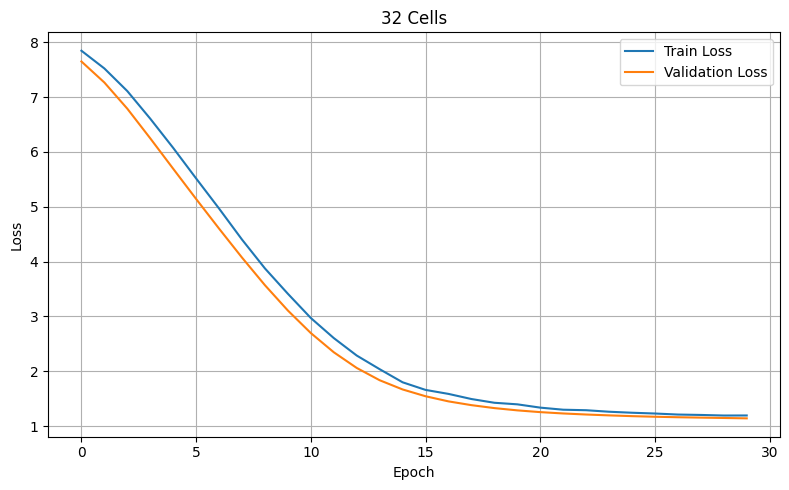


64 Cells
Epoch 1/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.0669 - loss: 7.8492 - val_accuracy: 0.4400 - val_loss: 7.4617
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.3551 - loss: 7.3258 - val_accuracy: 0.4400 - val_loss: 6.6599
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.3407 - loss: 6.4667 - val_accuracy: 0.4400 - val_loss: 5.5657
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.3642 - loss: 5.3405 - val_accuracy: 0.4400 - val_loss: 4.4002
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.3704 - loss: 4.1938 - val_accuracy: 0.4400 - val_loss: 3.3206
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.3741 - loss: 3.1327 - val_accuracy: 0.4400 - val_loss: 2.4291
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.3641 - loss: 2.3346 - val_accuracy: 0.4400 - val_loss: 1.8162
Epoch 8/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.4003 - loss: 1.7880 - val_accuracy: 0.4400 - val_los

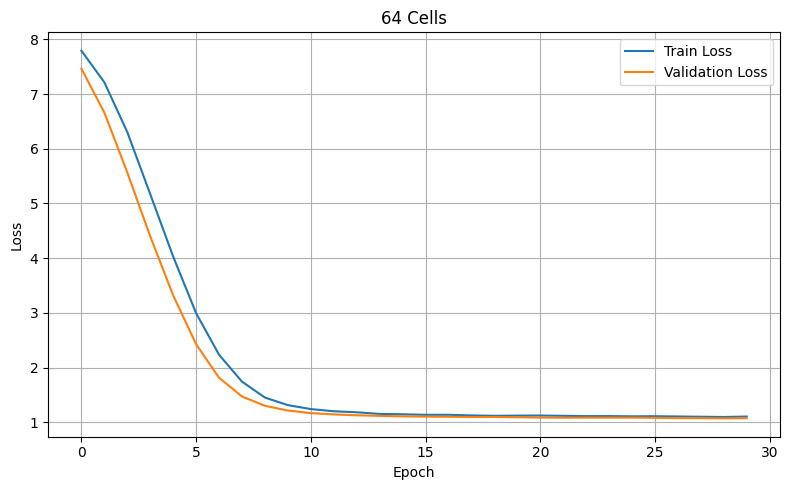


128 Cells
Epoch 1/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - accuracy: 0.0852 - loss: 7.8224 - val_accuracy: 0.3600 - val_loss: 6.9617
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.3917 - loss: 6.5867 - val_accuracy: 0.4400 - val_loss: 5.1159
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.4027 - loss: 4.6969 - val_accuracy: 0.4400 - val_loss: 3.1169
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.3549 - loss: 2.8058 - val_accuracy: 0.4400 - val_loss: 1.7162
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.3528 - loss: 1.6482 - val_accuracy: 0.4400 - val_loss: 1.2238
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.3731 - loss: 1.2372 - val_accuracy: 0.4400 - val_loss: 1.1193
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.3631 - loss: 1.1385 - val_accuracy: 0.4400 - val_loss: 1.0912
Epoch 8/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.4002 - loss: 1.1136 - val_accuracy: 0.3600 - val_lo

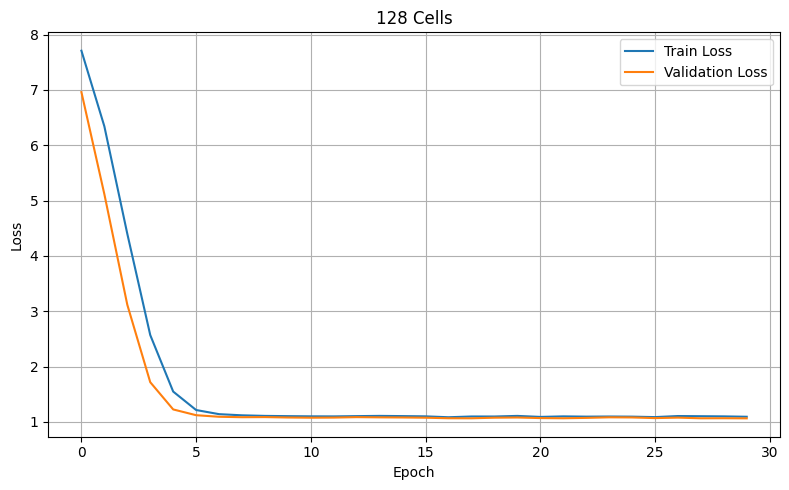


Unidirectional
Epoch 1/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - accuracy: 0.0494 - loss: 7.8770 - val_accuracy: 0.3600 - val_loss: 7.4924
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.3899 - loss: 7.3115 - val_accuracy: 0.3600 - val_loss: 6.6591
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.3720 - loss: 6.4307 - val_accuracy: 0.3600 - val_loss: 5.6427
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.3981 - loss: 5.3670 - val_accuracy: 0.3600 - val_loss: 4.5637
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.3574 - loss: 4.3205 - val_accuracy: 0.3600 - val_loss: 3.5350
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.3790 - loss: 3.3190 - val_accuracy: 0.3600 - val_loss: 2.6448
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.3889 - loss: 2.4607 - val_accuracy: 0.3600 - val_loss: 1.9800
Epoch 8/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.3753 - loss: 1.9050 - val_accuracy: 0.3600 - v

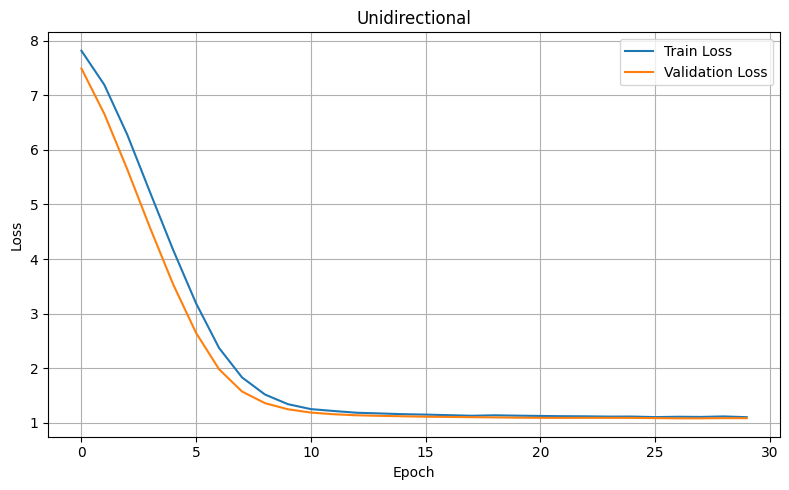


Bidirectional
Epoch 1/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 0.0838 - loss: 7.7982 - val_accuracy: 0.2400 - val_loss: 7.1964
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.3201 - loss: 6.9233 - val_accuracy: 0.2000 - val_loss: 6.0697
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.3760 - loss: 5.6925 - val_accuracy: 0.2000 - val_loss: 4.5708
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.3471 - loss: 4.2080 - val_accuracy: 0.2300 - val_loss: 3.0077
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.3496 - loss: 2.6783 - val_accuracy: 0.3600 - val_loss: 1.7884
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.3755 - loss: 1.6308 - val_accuracy: 0.3600 - val_loss: 1.2950
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.4316 - loss: 1.2375 - val_accuracy: 0.5100 - val_loss: 1.1352
Epoch 8/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.4518 - loss: 1.1313 - val_accuracy: 0.4400 - v

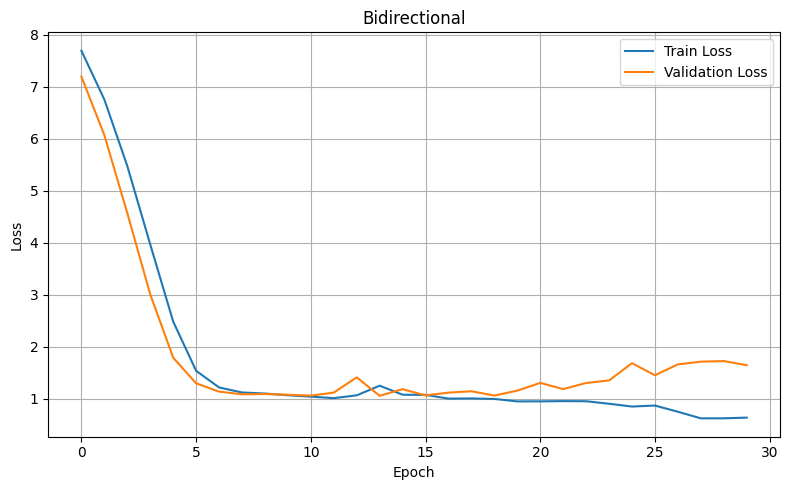


Bidirectional 2 Layers
Epoch 1/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - accuracy: 0.1193 - loss: 7.7210 - val_accuracy: 0.3600 - val_loss: 6.7182
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.3663 - loss: 6.3208 - val_accuracy: 0.3600 - val_loss: 4.8955
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.3700 - loss: 4.4464 - val_accuracy: 0.3600 - val_loss: 2.9812
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.3481 - loss: 2.6325 - val_accuracy: 0.3600 - val_loss: 1.6702
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.4113 - loss: 1.5315 - val_accuracy: 0.3600 - val_loss: 1.2325
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.3710 - loss: 1.2194 - val_accuracy: 0.3600 - val_loss: 1.1241
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.3868 - loss: 1.1369 - val_accuracy: 0.3600 - val_loss: 1.0902
Epoch 8/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.3808 - loss: 1.1091 - val_accuracy: 0

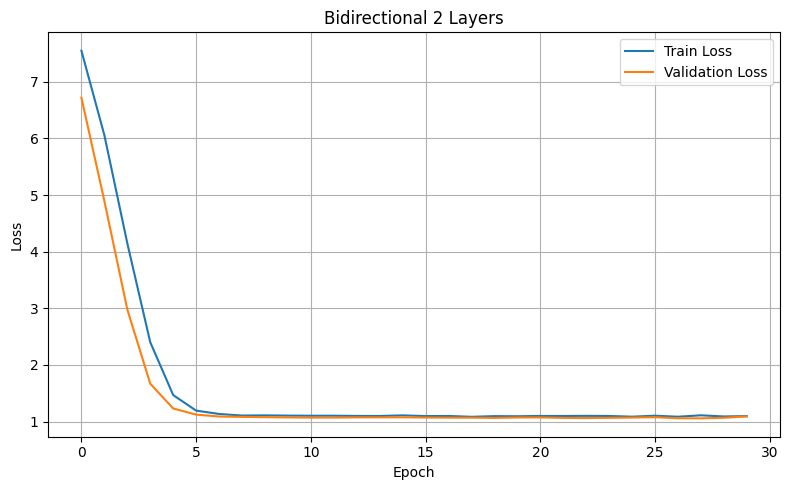

In [92]:
import matplotlib.pyplot as plt

n = 0

for model in rnn_models:
    print(name_layers[n])
    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=['accuracy']
    )
    history = model.fit(
        vectorizer_data, y_train_int,
        epochs=30,
        batch_size=64,
        validation_split=0.2
    )
    test_loss, test_acc = model.evaluate(vectorizer_val, y_valid_int)

    y_pred_probs = model.predict(vectorizer_val)
    y_pred = np.argmax(y_pred_probs, axis=1)
    f1 = f1_score(y_valid_int, y_pred, average='macro')

    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"F1 Score: {f1:.4f}")

    plt.figure(figsize=(8, 5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(name_layers[n])
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    n += 1
    print()

